In [1]:
#Here we will find a conventional treatment plan for real patient to make sure it makes sense
#Also, will check and incorporate smoothing

In [2]:
import numpy as np
import scipy.optimize
import pandas as pd
import operator
import scipy.io
import scipy
import scipy.sparse
import time
import sys

In [3]:
sys.path.append('/home/rilevin/MMORT/mmort')
from optimization_tools import *
from experiments import *

In [4]:
data = scipy.io.loadmat('data/ProstateExample_BODY_not_reduced_with_OAR_constraints.mat')
Alpha = np.array([0.35, 0.35])
Beta = np.array([0.175, 0.175])
Gamma = np.array([np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35])               
                 ])
Delta = np.array([np.array([0.07, 0.07]),
                  np.array([0.07, 0.07]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175])                
                 ])
modality_names = np.array(['Aphoton', 'Aproton'])

In [5]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [6]:
#redo this one
def objective_N(N,  Alpha = Alpha, Beta = Beta, Gamma = Gamma, Delta = Delta, data = data, modality_names = modality_names):
    T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
    num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
    #Assuming N>0, and two-modality case
    Rx = 80
    LHS1 = T_list[0]
    LHS2 = T_list[1]
    RHS1 = np.array([Rx/(np.sum(N))]*LHS1.shape[0])
    RHS2 = np.array([Rx/(np.sum(N))]*LHS2.shape[0])

    print('I am HERE')
    u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-4, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
    u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-4, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)
    
    
    u_init11 = np.concatenate([u1_guess, u2_guess])
#     u_init11 = 10*np.ones(2289+16358)
    print("GOT HERE!")
    u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.1, ftol = 1e-3, max_iter = 300, verbose = 1)
    
    return obj_u_opt_N_opt(u, T, alpha, B, N, num_tumor_voxels, Td = 10)

def informative_objective_N(N,  Alpha = Alpha, Beta = Beta, Gamma = Gamma, Delta = Delta, data = data, modality_names = modality_names):
    T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
    num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
    #Assuming N>0, and two-modality case
    Rx = 80
    LHS1 = T_list[0]
    LHS2 = T_list[1]
    RHS1 = np.array([Rx/(np.sum(N))]*LHS1.shape[0])
    RHS2 = np.array([Rx/(np.sum(N))]*LHS2.shape[0])

#     u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-1, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
#     u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-1, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)
    
#     u_init11 = np.concatenate([u1_guess, u2_guess])
#     u_init11 = 10*np.ones(2289+16358)
    u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 1)
    
    return u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history, obj_u_opt_N_opt(u, T, alpha, B, N, num_tumor_voxels, Td = 10)



def optimize_N(N_init, N_SUM_MAX = 45, max_iter = 6):
    """Value function of N optimization as per Algorithm 1 of the paper.
    Uses trust-region-constrained from scipy

    Parameters
    ----------
    N_init : np.array of shape (M,), where M is the number of modalities
        Initial array of fractions
    N_SUM_MAX : float
        Max treatment course length, the bound on the sum of N
    max_iter : int
        Max number of iterations

    Returns
    -------
    x : np.array of shape (M,)
        Optimal fractionation schedule N
    res : OptimizationResult from scipy
        Metadata of the algorithm
    Nk_hist : list
        Iterates N history 
    """
    Nk_hist = []
    def callback(xk, OptRes):
        Nk_hist.append(xk)
        return 0

    bounds =  scipy.optimize.Bounds([1, 1], [np.inf, np.inf]) #or 0,0
    linear_constraint = scipy.optimize.LinearConstraint(np.array([1,1]), -np.inf, N_SUM_MAX)
   
    x0 = np.array(N_init)
    res = scipy.optimize.minimize(objective_N, x0, method='trust-constr',  jac="2-point", hess=BFGS(), 
                         constraints=[linear_constraint], options={'verbose': 4, 'maxiter': max_iter}, bounds=bounds, 
                         callback = callback)
    x = res.x
    print('NEW N rounded:', np.rint(x), 'EXACT new N:', x)
    return x, res, obj_Nk_hist, Nk_hist


In [7]:
T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(np.array([43,1]), Alpha, Beta, Gamma, Delta, data, modality_names)
# u_init = 10*np.ones(2289+16358)

getting through 11912 matrices


In [8]:
#     T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
#     num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
#Assuming N>0, and two-modality case
N = np.array([43, 1])
Rx = 80
LHS1 = T_list[0]
LHS2 = T_list[1]
RHS1 = np.array([Rx/np.sum(N)]*LHS1.shape[0])
RHS2 = np.array([Rx/np.sum(N)]*LHS2.shape[0])

print('I am HERE')
u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)


I am HERE
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.7695e-01, final cost 1.2601e-01, first-order optimality 6.71e-03.
The first-order optimality measure is less than `tol`.
Number of iterations 7, initial cost 1.1198e+00, final cost 7.1103e-01, first-order optimality 8.94e-04.


In [9]:
u_init11 = np.concatenate([u1_guess, u2_guess])
#u_init11 = np.concatenate([u_conv, np.zeros(u2_guess.shape[0])]) 

In [10]:
u_mult, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 1)

The relative change of the cost function is less than `tol`.
Number of iterations 7, initial cost 1.4105e+07, final cost 1.3515e+07, first-order optimality 7.24e+04.
    iter = 1, stopping criterium:254503173.1615124, OBJ -270718.124927415
    This iteration took: 10.947010278701782


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The relative change of the cost function is less than `tol`.
Number of iterations 11, initial cost 8.4814e+06, final cost 7.5882e+06, first-order optimality 3.73e+04.
    iter = 2, stopping criterium:0.4517514737546604, OBJ -250256.36074597418
    This iteration took: 11.105583429336548
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 6.6523e+06, final cost 5.1651e+06, first-order optimality 1.59e+04.
    iter = 3, stopping criterium:0.34160201409524404, OBJ -239825.13347118688
    This iteration took: 21.38856339454651
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 5.4977e+06, final cost 3.0425e+06, first-order optimality 6.88e+03.
    iter = 4, stopping criterium:0.4576999548580222, OBJ -235251.92878218228
    This iteration took: 20.445362329483032
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.4783e+06, final cost 2.4323e+06, first-order optimality 1.14e+04.
    iter = 5, 

The relative change of the cost function is less than `tol`.
Number of iterations 16, initial cost 5.3143e+06, final cost 3.5729e+05, first-order optimality 4.73e+03.
    iter = 32, stopping criterium:0.02983280825261869, OBJ -241692.74361185305
    This iteration took: 13.668668270111084
The relative change of the cost function is less than `tol`.
Number of iterations 16, initial cost 5.1515e+06, final cost 3.4297e+05, first-order optimality 2.70e+03.
    iter = 33, stopping criterium:0.057169973427208025, OBJ -241393.16370999705
    This iteration took: 11.901756763458252
The relative change of the cost function is less than `tol`.
Number of iterations 24, initial cost 5.1110e+06, final cost 3.3598e+05, first-order optimality 1.88e+03.
    iter = 34, stopping criterium:0.02974724001674241, OBJ -241640.35356438597
    This iteration took: 15.84122109413147
The relative change of the cost function is less than `tol`.
Number of iterations 13, initial cost 4.5683e+06, final cost 3.3923e+

The relative change of the cost function is less than `tol`.
Number of iterations 8, initial cost 8.9166e+05, final cost 2.9680e+05, first-order optimality 4.75e+03.
    iter = 4, stopping criterium:0.0013071520067569763, OBJ -239784.9945863145
    This iteration took: 8.604626417160034
The relative change of the cost function is less than `tol`.
Number of iterations 8, initial cost 8.5979e+05, final cost 2.9637e+05, first-order optimality 4.97e+03.
    iter = 5, stopping criterium:0.00324038538007222, OBJ -240216.4840826251
    This iteration took: 8.87671184539795
The relative change of the cost function is less than `tol`.
Number of iterations 8, initial cost 8.2649e+05, final cost 2.9635e+05, first-order optimality 5.15e+03.
    iter = 6, stopping criterium:0.003402938739987288, OBJ -240708.9011256608
    This iteration took: 8.863227605819702
The relative change of the cost function is less than `tol`.
Number of iterations 8, initial cost 8.0769e+05, final cost 2.9658e+05, first-o

    iter = 20, stopping criterium:0.004102988902548598, OBJ -229703.31325610838
    This iteration took: 8.902860641479492
The relative change of the cost function is less than `tol`.
Number of iterations 8, initial cost 7.2910e+05, final cost 6.6575e+04, first-order optimality 6.26e+03.
    iter = 21, stopping criterium:0.0009606372994446323, OBJ -229593.02875082626
    This iteration took: 8.57001256942749
No improvement, exiting
Finding the correct solution:
# of violated constr: 0
OBJJJJJ: -241781.51598662592


In [12]:
T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(np.array([45,0]), Alpha, Beta, Gamma, Delta, data, modality_names)
# u_init = 10*np.ones(2289+16358)

getting through 11912 matrices


In [30]:
%%time
u_conv, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u1_guess, T, H, alpha, gamma, B, D, C, eta_step = 0.1, ftol = 1e-3, max_iter = 300, verbose = 1)

The relative change of the cost function is less than `tol`.
Number of iterations 9, initial cost 8.5291e+05, final cost 6.9521e+05, first-order optimality 9.38e+03.
    iter = 1, stopping criterium:2528638.750130594, OBJ -239887.02694326988
    This iteration took: 6.844566583633423
The relative change of the cost function is less than `tol`.
Number of iterations 9, initial cost 4.4976e+05, final cost 3.1787e+05, first-order optimality 3.75e+03.
    iter = 2, stopping criterium:0.9141725963494293, OBJ -233425.9521623608
    This iteration took: 5.942252159118652
The relative change of the cost function is less than `tol`.
Number of iterations 9, initial cost 4.2994e+05, final cost 2.9617e+05, first-order optimality 2.80e+03.
    iter = 3, stopping criterium:0.03628322981666915, OBJ -232777.714934126
    This iteration took: 5.850969552993774
The relative change of the cost function is less than `tol`.
Number of iterations 9, initial cost 4.3490e+05, final cost 2.9304e+05, first-order 

The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.3674e+05, final cost 9.3235e+03, first-order optimality 7.12e+02.
    iter = 6, stopping criterium:0.019050679985683498, OBJ -215982.32679944363
    This iteration took: 10.069178819656372
The unconstrained solution is optimal.
Final cost 1.3351e+04, first-order optimality 1.68e+03
    iter = 7, stopping criterium:0.03632577300028493, OBJ -211849.8413434084
    This iteration took: 2.3294732570648193
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 2.4851e+05, final cost 8.7017e+03, first-order optimality 6.53e+02.
    iter = 8, stopping criterium:0.021610178316059436, OBJ -212441.6716756472
    This iteration took: 10.712987899780273
The unconstrained solution is optimal.
Final cost 1.2647e+04, first-order optimality 1.73e+03
    iter = 9, stopping criterium:0.03242879456838518, OBJ -208762.45211450043
    This iteration took: 2.2724602222442627
The maximum number o

CPU times: user 31.2 ms, sys: 144 ms, total: 175 ms
Wall time: 171 ms


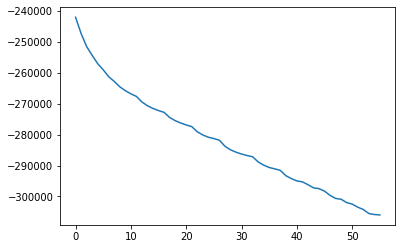

In [29]:
%%time
import matplotlib.pyplot as plt
plt.plot(auto_param_obj_history[1])

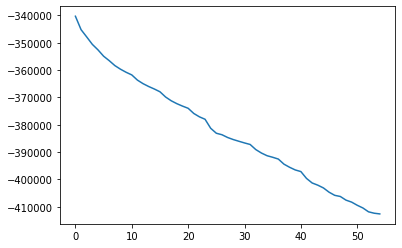

In [24]:
plt.plot(auto_param_relaxed_obj_history[1][3:])